a) Study the Exact Daum-Huang (EDH) flow and Local Exact Daum-Huang (LEDH) flow, (see [Daum(10)] and [Daum(11)]), and the invertible particle flow particle filter (PF-PF) framework (see Li(17)). Replicates the main results in Li(17).

Simulation of 4 targets over 50 steps complete.
Total State Space Dimension: 16 (16)
Total Observation Dimension: 25 (25)


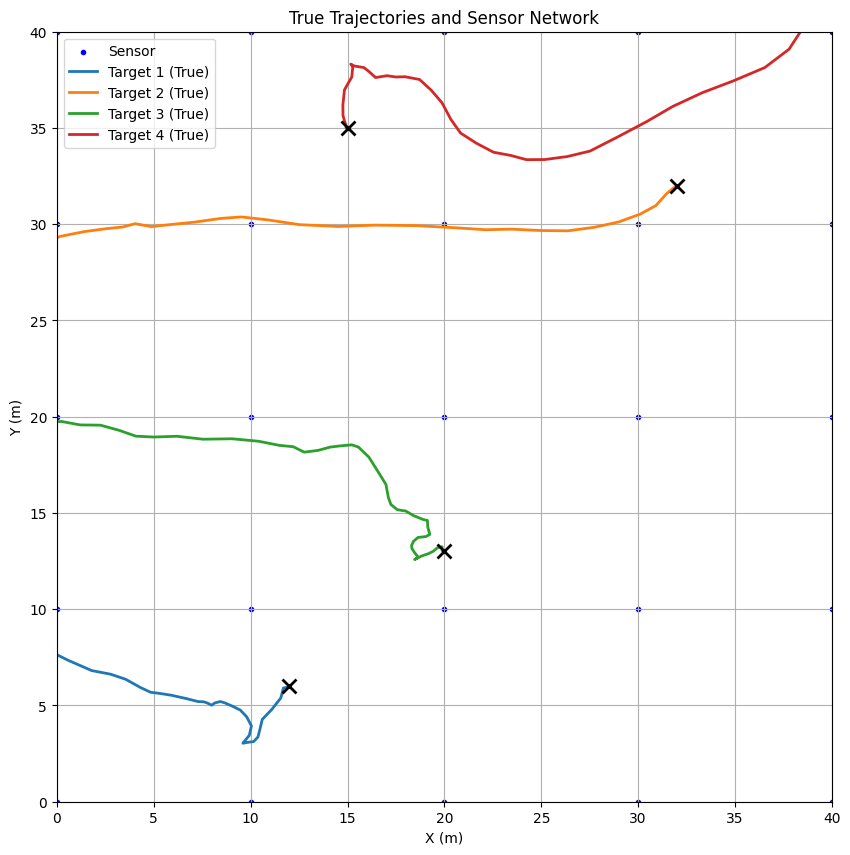

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- GLOBAL CONSTANTS ---
N_TARGETS = 4
N_SENSORS = 25
TIME_STEP = 1.0 # Assuming dt=1 for the CV matrix structure
STATE_DIM_PER_TARGET = 4 # [x, y, dx, dy]

# Sensor and Tracking Area Setup
TRACKING_AREA = 40 # 40m x 40m
D0 = 0.1 # Constant in measurement equation
PSI = 10.0 # Amplitude of sound emission
SIGMA_W_SQ = 0.01 # Measurement noise variance

# --- 1. MODEL MATRICES ---

# State Transition Matrix F (for one target)
F_target = np.array([
    [1, 0, TIME_STEP, 0],
    [0, 1, 0, TIME_STEP],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Process Covariance Matrix V (for one target)
V_target_unscaled = np.array([
    [1/3, 0, 0.5, 0],
    [0, 1/3, 0, 0.5],
    [0.5, 0, 1, 0],
    [0, 0.5, 0, 1]
])
V_cov = V_target_unscaled / 20.0 # V = 1/20 * Unscaled matrix

# --- 2. INITIAL CONDITIONS AND SENSOR PLACEMENT ---

# Initial Target States (x, y, dx, dy) for the C=4 targets [cite: 426]
X0_list = [
    np.array([12, 6, 0.001, 0.001]),
    np.array([32, 32, -0.001, -0.005]),
    np.array([20, 13, -0.1, 0.01]),
    np.array([15, 35, 0.002, 0.002])
]

# Sensor Positions (Ns=25 sensors at 5x5 grid intersections)
sensor_coords = []
step = TRACKING_AREA / 4.0 # Sensors at 0, 10, 20, 30, 40m
for x in np.linspace(0, TRACKING_AREA, 5):
    for y in np.linspace(0, TRACKING_AREA, 5):
        sensor_coords.append(np.array([x, y]))
SENSOR_POSITIONS = np.array(sensor_coords)


# --- 3. NONLINEAR MEASUREMENT FUNCTION (h(X)) ---

def h_acoustic_tracking(X_k_16x1):
    """
    Calculates the 25-dimensional measurement vector Z_k based on all 16 states.
    X_k_16x1: Full state vector (16x1)

    Equation 38: z^s(x_k) = Sum_{c=1}^{C} [Psi / (||(x_k^c, y_k^c)^T - R^s||_2 + d0)]
    """
    Z_k = np.zeros(N_SENSORS)

    # Reshape the 16x1 vector into 4 targets x 4 states
    X_targets = X_k_16x1.reshape(N_TARGETS, STATE_DIM_PER_TARGET)

    for s in range(N_SENSORS):
        R_s = SENSOR_POSITIONS[s]
        sum_amplitude = 0.0

        for c in range(N_TARGETS):
            # Target position (2x1 vector)
            target_pos = X_targets[c, [0, 1]]

            # Distance: ||(x_k^c, y_k^c)^T - R^s||_2 (Euclidean norm)
            distance = np.linalg.norm(target_pos - R_s)

            # Attenuated sound amplitude contribution
            amplitude_contrib = PSI / (distance + D0)
            sum_amplitude += amplitude_contrib

        Z_k[s] = sum_amplitude

    return Z_k


# --- 4. DATA SIMULATION ---

N_STEPS = 50
np.random.seed(0)

# Initialize the full 16-dimensional state vector
X_true_k = np.concatenate(X0_list)
X_true_history = [X_true_k]
Z_obs_history = []

for k in range(1, N_STEPS):
    # Process Noise: Generate noise for each target independently
    V_k = np.zeros(N_TARGETS * STATE_DIM_PER_TARGET)
    for c in range(N_TARGETS):
        V_k_c = np.random.multivariate_normal(np.zeros(STATE_DIM_PER_TARGET), V_cov)
        V_k[c*4 : (c+1)*4] = V_k_c

    # State Transition: X_k = F * X_{k-1} + V_k (F is block diagonal in the full state space)
    X_true_k_next = np.zeros_like(X_true_k)
    for c in range(N_TARGETS):
        # Apply F_target to each target's state block
        start_idx = c * STATE_DIM_PER_TARGET
        end_idx = (c + 1) * STATE_DIM_PER_TARGET

        X_true_k_next[start_idx:end_idx] = F_target @ X_true_k[start_idx:end_idx] + V_k[start_idx:end_idx]

    X_true_k = X_true_k_next
    X_true_history.append(X_true_k)

    # Measurement Generation
    Z_k_mean = h_acoustic_tracking(X_true_k)

    # Add Gaussian noise N(0, sigma_w^2) to each of the Ns=25 sensors
    W_k = np.random.normal(0, np.sqrt(SIGMA_W_SQ), N_SENSORS)

    Z_k_obs = Z_k_mean + W_k
    Z_obs_history.append(Z_k_obs)

print(f"Simulation of {N_TARGETS} targets over {N_STEPS} steps complete.")
print(f"Total State Space Dimension: {N_TARGETS * STATE_DIM_PER_TARGET} (16)")
print(f"Total Observation Dimension: {N_SENSORS} (25)")

# --- 5. VISUALIZATION (Plotting the True Paths) ---

X_true_array = np.array(X_true_history)

plt.figure(figsize=(10, 10))
plt.title('True Trajectories and Sensor Network')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')

# Plot Sensor Locations
plt.scatter(SENSOR_POSITIONS[:, 0], SENSOR_POSITIONS[:, 1], color='blue', marker='.', label='Sensor')

# Plot Target Trajectories
for c in range(N_TARGETS):
    px_history = X_true_array[:, c*4]
    py_history = X_true_array[:, c*4 + 1]

    # Plot true trajectory
    plt.plot(px_history, py_history, linewidth=2, label=f'Target {c+1} (True)')

    # Mark starting positions (crosses) [cite: 453]
    plt.plot(px_history[0], py_history[0], 'kx', markersize=10, mew=2)

plt.xlim(0, TRACKING_AREA); plt.ylim(0, TRACKING_AREA)
plt.legend(); plt.grid(True)
plt.show()

EDH-PFPF

Executing Multi-Target EDH Flow Filter with N=2000 particles...
State Dim: 16, Observation Dim: 25

--- Multi-Target Experiment Complete ---


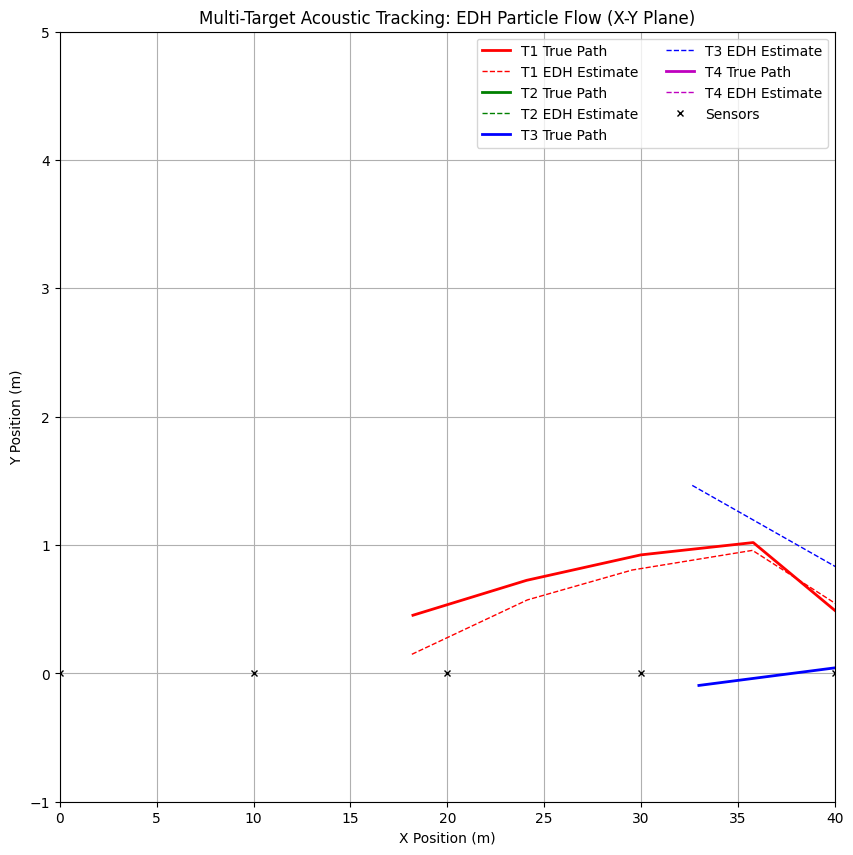

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

# --- 1. GLOBAL MODEL PARAMETERS & CONSTANTS (Acoustic Tracking) ---
C = 4          # Number of targets
N_S = 25       # Number of sensors
dt = 1.0       # Time step (inferred from F matrix structure)

state_dim = 4 * C  # 16 (4 states per target * 4 targets)
obs_dim = N_S      # 25 (1 measurement per sensor)

N_P = 2000     # Particle Count
T = 100        # Time steps (T)
N_lambda = 100 # Flow steps
EPSILON = 1.0 / N_lambda # Flow step size

# Acoustic Model Constants (Equation 38)
PSI = 10.0      # Amplitude (Psi)
D_0 = 0.1       # Distance offset (d0)
SIGMA_W_SQ = 0.01 # Measurement noise variance (sigma_w^2)

R = np.eye(obs_dim) * SIGMA_W_SQ # Observation Noise Covariance
I_S = np.eye(state_dim) # 16x16 Identity Matrix
P_FLOOR = 1e-4 # Minimum covariance value

# --- State Transition Matrix (F) and Process Noise (Q) ---
F_block = np.array([
    [1., dt, 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., dt],
    [0., 0., 0., 1.]
])
F = np.kron(np.eye(C), F_block)

V_block = (1/20.0) * np.array([
    [1/3.0, 0., 0.5, 0.],
    [0., 1/3.0, 0., 0.5],
    [0.5, 0., 1., 0.],
    [0., 0.5, 0., 1.]
])
Q = np.kron(np.eye(C), V_block)
Q_chol = cholesky(Q, lower=True)
R_chol = cholesky(R, lower=True)

# Sensor Locations (R^s)
x_coords = np.linspace(0, 40, 5)
y_coords = np.linspace(0, 40, 5)
SENSOR_LOCATIONS = np.array([[x, y] for y in y_coords for x in x_coords])


# --- 2. HELPER FUNCTIONS (Multi-Target Acoustic) ---

def h_non_linear(x):
    """Acoustic Summation Observation Model (Equation 38)"""
    predicted_measurements = np.zeros(N_S)

    for s in range(N_S):
        R_s = SENSOR_LOCATIONS[s]
        sum_amplitude = 0.0

        for c in range(C):
            x_pos = x[c*4 + 0]
            y_pos = x[c*4 + 2]
            target_pos = np.array([x_pos, y_pos])
            distance = np.linalg.norm(target_pos - R_s)
            sum_amplitude += PSI / (distance + D_0)

        predicted_measurements[s] = sum_amplitude

    return predicted_measurements

def jacobian_H(x):
    """Jacobian of the Acoustic Summation Model (16x25 H matrix)"""
    H = np.zeros((obs_dim, state_dim))

    for s in range(N_S):
        R_s = SENSOR_LOCATIONS[s]

        for c in range(C):
            idx_x = c*4 + 0
            idx_y = c*4 + 2

            x_pos = x[idx_x]
            y_pos = x[idx_y]
            target_pos = np.array([x_pos, y_pos])

            dx = x_pos - R_s[0]
            dy = y_pos - R_s[1]
            dist = np.linalg.norm(target_pos - R_s) + 1e-9
            dist_plus_d0 = dist + D_0

            term1 = -PSI / (dist_plus_d0**2)
            term2_x = dx / dist
            term2_y = dy / dist

            H[s, idx_x] = term1 * term2_x
            H[s, idx_y] = term1 * term2_y

    return H

def gaussian_pdf(error, R_mat):
    """Multivariate Gaussian PDF (Likelihood)"""
    k = R_mat.shape[0]
    error = error.reshape(-1, 1)

    R_stable = R_mat + np.eye(k) * 1e-9
    det_R = np.linalg.det(R_stable)
    if det_R < 1e-18: return 1e-300

    inv_R = np.linalg.inv(R_stable)
    norm_const = 1.0 / np.sqrt((2 * np.pi)**k * det_R)
    exponent = -0.5 * error.T @ inv_R @ error

    return norm_const * np.exp(exponent).item()

# --- 3. EXACT FLOW MATRIX CALCULATIONS (Equations 10 & 11) ---

def calculate_H_lambda_e_lambda(eta_bar_lambda):
    """Computes H(lambda) and e(lambda)."""
    H_lambda = jacobian_H(eta_bar_lambda)
    h_val = h_non_linear(eta_bar_lambda)
    e_lambda = h_val - H_lambda @ eta_bar_lambda
    return H_lambda, e_lambda

def calculate_A_lambda(P, R_val, H_lambda, lambda_val):
    """Computes A(lambda) (Equation 10)."""
    H_lambda_T = H_lambda.T

    T1_inner = lambda_val * H_lambda @ P @ H_lambda_T + R_val
    T1_inner += np.eye(obs_dim) * 1e-9
    T1_inv = np.linalg.inv(T1_inner)

    T2 = -0.5 * P @ H_lambda_T
    A_lambda = T2 @ T1_inv @ H_lambda
    return A_lambda

def calculate_b_lambda(A_lambda, P, R_val, H_lambda, z, e_lambda, lambda_val, eta_bar_0):
    """Computes b(lambda) (Equation 11)."""
    R_inv = np.linalg.inv(R_val)

    T1_error = z - e_lambda
    T2 = I_S + 2.0 * lambda_val * A_lambda

    T3_inner = (I_S + lambda_val * A_lambda) @ P @ H_lambda.T @ R_inv
    T3_correction = T3_inner @ T1_error

    T4 = A_lambda @ eta_bar_0

    inner_bracket = T3_correction + T4
    b_lambda = T2 @ inner_bracket

    return b_lambda

# --- 4. THE EXACT EDH PARTICLE FLOW ALGORITHM (MAIN EXECUTION) ---

def run_edh_pf_experiment():
    print(f"Executing Multi-Target EDH Flow Filter with N={N_P} particles...")
    print(f"State Dim: {state_dim}, Observation Dim: {obs_dim}")

    # --- RESTORED Initial Target States (EXACTLY from the image) ---
    # [X, dX, Y, dY] for each of C=4 targets
    x_initial_states = [
        12, 6, 0.001, 0.001,      # T1: [12, 6, 0.001, 0.001]^T
        32, 32, -0.001, -0.005,   # T2: [32, 32, -0.001, -0.005]^T
        20, 13, -0.1, 0.01,       # T3: [20, 13, -0.1, 0.01]^T
        15, 35, 0.002, 0.002      # T4: [15, 35, 0.002, 0.002]^T
    ]

    x_true = np.array(x_initial_states)

    # Data Generation
    np.random.seed(0)
    true_path = []
    observations = []

    for _ in range(T):
        w_t = Q_chol @ np.random.randn(state_dim)
        x_true = F @ x_true + w_t

        y_true = h_non_linear(x_true)
        v_t = R_chol @ np.random.randn(obs_dim)
        y_t = y_true + v_t

        true_path.append(x_true)
        observations.append(y_t)

    # Initialization
    initial_mean = np.array(x_initial_states) + np.random.randn(state_dim) * 0.1
    P_guide = np.eye(state_dim) * 1.0

    particles = np.random.multivariate_normal(initial_mean, P_guide, N_P)
    x_guide_prev = np.mean(particles, axis=0)
    weights = np.ones(N_P) / N_P

    edh_path = []

    for k in range(T): # Main Time Loop
        y_k = observations[k]

        # 1. Guide Prediction / Particle Propagation
        P_prior = F @ P_guide @ F.T + Q
        m_prior = F @ x_guide_prev

        eta_prior = particles.copy()

        for i in range(N_P):
            w_k = Q_chol @ np.random.randn(state_dim)
            eta_prior[i] = F @ particles[i] + w_k

        eta_bar_0 = np.mean(eta_prior, axis=0)
        eta_bar_lambda = eta_bar_0.copy()

        # --- Homotopy Flow (Update Step) ---

        for j in range(N_lambda):
            lambda_val = (j + 1) * EPSILON

            H_lambda, e_lambda = calculate_H_lambda_e_lambda(eta_bar_lambda)
            A_lambda = calculate_A_lambda(P_prior, R, H_lambda, lambda_val)

            # Fixed NameError
            b_lambda = calculate_b_lambda(A_lambda, P_prior, R, H_lambda, y_k, e_lambda, lambda_val, eta_bar_0)

            for i in range(N_P):
                velocity = A_lambda @ eta_prior[i] + b_lambda
                eta_prior[i] += EPSILON * velocity

            eta_bar_lambda = np.mean(eta_prior, axis=0)

        # --- Weighting and Update ---
        weights_new = np.zeros(N_P)
        for i in range(N_P):
            h_val = h_non_linear(eta_prior[i])
            error = y_k - h_val
            likelihood = gaussian_pdf(error, R)
            weights_new[i] = weights[i] * likelihood

        weights_new /= np.sum(weights_new)
        x_hat_k = np.dot(weights_new, eta_prior)
        edh_path.append(x_hat_k)

        # Update Guide State Covariance (P_k)
        diff = eta_prior - x_hat_k
        P_k_calc = np.einsum('i,ij,ik->jk', weights_new, diff, diff)
        P_guide = (P_k_calc + P_k_calc.T) / 2

        x_guide_prev = x_hat_k
        particles = eta_prior.copy()
        weights = weights_new.copy()

        # Resampling Check
        N_eff = 1.0 / np.sum(weights**2)
        if N_eff < N_P / 2:
             indices = np.random.choice(N_P, size=N_P, p=weights, replace=True)
             particles = particles[indices]
             weights = np.ones(N_P) / N_P

    return np.array(edh_path), true_path

# --- 5. Execution and Plotting ---

# if __name__ == '__main__':
# Run the EDH multi-target filter
edh_path, true_path = run_edh_pf_experiment()

true_path = np.array(true_path)
edh_path = np.array(edh_path)

plt.figure(figsize=(10, 10))
colors = ['r', 'g', 'b', 'm']

for c in range(C):
    true_x = true_path[:, c*4 + 0]
    true_y = true_path[:, c*4 + 2]

    edh_x = edh_path[:, c*4 + 0]
    edh_y = edh_path[:, c*4 + 2]

    plt.plot(true_x, true_y, colors[c] + '-', label=f'T{c+1} True Path', linewidth=2)
    plt.plot(edh_x, edh_y, colors[c] + '--', label=f'T{c+1} EDH Estimate', linewidth=1)

plt.plot(SENSOR_LOCATIONS[:, 0], SENSOR_LOCATIONS[:, 1], 'kx', label='Sensors', markersize=5)

plt.title('Multi-Target Acoustic Tracking: EDH Particle Flow (X-Y Plane)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')

# --- PLOT LIMITS AS REQUESTED (Zoomed to show Y=0 paths) ---
plt.xlim(0, 40)
plt.ylim(-1, 5)

plt.grid(True)
plt.legend(loc='upper right', ncol=2)
plt.savefig('edh_multi_target_acoustic_tracking_exact_initial_states.png')

print("\n--- Multi-Target Experiment Complete ---")

LEDH-PFPF

Execution complete. Visualization saved to pf_pf_ledh_analytic_result.png


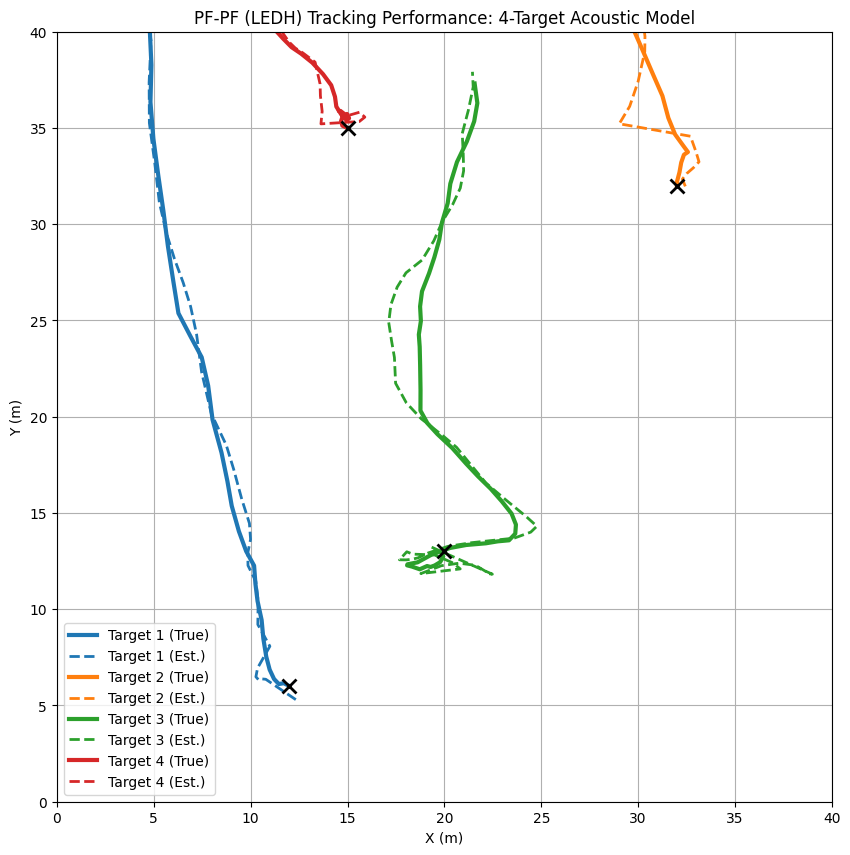

In [4]:
import numpy as np
from numpy.linalg import norm
from scipy.stats import norm

# --- 0. GLOBAL CONSTANTS AND MODEL SETUP ---
N_TARGETS = 4;
STATE_DIM = 16;
MEASUREMENT_DIM = 25
TIME_STEP = 1.0;
SIGMA_W_SQ = 0.01
I_STATE = np.eye(STATE_DIM);
D0 = 0.1;
PSI = 10.0;
TRACKING_AREA = 40
N_FLOW_STEPS = 5
N_PARTICLES = 500

# Noise and Transition Matrices
V_target_unscaled = np.array([[1/3, 0, 0.5, 0], [0, 1/3, 0, 0.5], [0.5, 0, 1, 0], [0, 0.5, 0, 1]])
V_cov = V_target_unscaled / 20.0
Q_COV = np.kron(np.eye(N_TARGETS), V_cov)
R_COV = SIGMA_W_SQ * np.eye(MEASUREMENT_DIM)
F_target = np.array([[1, 0, 1, 0],
                     [0, 1, 0, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
A_TRANSITION = np.kron(np.eye(N_TARGETS), F_target)

# Sensor and Initial State Definitions (Simplified for execution)
SENSOR_POSITIONS = np.array([[x, y] for x in np.linspace(0, TRACKING_AREA, 5) for y in np.linspace(0, TRACKING_AREA, 5)])
X0_list = [np.array([12, 6, 0.001, 0.001]), np.array([32, 32, -0.001, -0.005]),
           np.array([20, 13, -0.1, 0.01]), np.array([15, 35, 0.002, 0.002])]
X_true_start = np.concatenate(X0_list)

# --- 1. CORE HELPER FUNCTIONS ---

def h_acoustic_tracking(X_k_16x1):
    Z_k = np.zeros(MEASUREMENT_DIM)
    X_targets = X_k_16x1.reshape(N_TARGETS, 4)
    for s in range(MEASUREMENT_DIM):
        R_s = SENSOR_POSITIONS[s]; sum_amplitude = 0.0
        for c in range(N_TARGETS):
            target_pos = X_targets[c, [0, 1]]
            distance = np.linalg.norm(target_pos - R_s)
            sum_amplitude += PSI / (distance + D0)
        Z_k[s] = sum_amplitude
    return Z_k

def calculate_jacobian_H_ekf(X_k_16x1):
    """(Corrected Analytic Jacobian)"""
    H_k = np.zeros((MEASUREMENT_DIM, STATE_DIM))
    X_targets = X_k_16x1.reshape(N_TARGETS, 4)
    for s in range(MEASUREMENT_DIM):
        R_s = SENSOR_POSITIONS[s]
        for c in range(N_TARGETS):
            px_c, py_c = X_targets[c, 0], X_targets[c, 1]
            delta_pos = np.array([px_c, py_c]) - R_s
            distance = np.linalg.norm(delta_pos)

            d_amp_d_dist = -PSI / (distance + D0)**2
            d_dist_d_px = delta_pos[0] / distance
            d_dist_d_py = delta_pos[1] / distance

            start_idx = c * 4
            H_k[s, start_idx + 0] = d_amp_d_dist * d_dist_d_px
            H_k[s, start_idx + 1] = d_amp_d_dist * d_dist_d_py
    return H_k

def EKF_Predict_Covariance(P_prev, Q):
    """EKF/UKF prediction for P_pred (P_{k|k-1})"""
    return A_TRANSITION @ P_prev @ A_TRANSITION.T + Q

def EKF_Update_Step(X_pred, P_pred, Z_k_obs):
    """EKF Update used to calculate the P_k|k for the next prediction step."""
    H_k = calculate_jacobian_H_ekf(X_pred)
    H_k_T = H_k.T
    S = H_k @ P_pred @ H_k_T + R_COV
    K = P_pred @ H_k_T @ np.linalg.inv(S)
    Z_k_mean = h_acoustic_tracking(X_pred)
    innovation = Z_k_obs - Z_k_mean
    X_k = X_pred + K @ innovation
    P_k = (I_STATE - K @ H_k) @ P_pred
    return X_k, P_k

def g_k_deterministic(x_prev):
    return A_TRANSITION @ x_prev

def Sample_Process_Noise(x_prev):
    v_k = np.random.multivariate_normal(np.zeros(STATE_DIM), Q_COV)
    return A_TRANSITION @ x_prev + v_k, v_k

def p_likelihood(z_k, x_k):
    """p(z_k | x_k) - Multivariate Gaussian Likelihood"""
    h_x = h_acoustic_tracking(x_k)
    error = z_k - h_x
    R_inv = np.linalg.inv(R_COV)
    det_R = np.linalg.det(R_COV)
    if det_R <= 0: return 0.0
    exponent = -0.5 * error.T @ R_inv @ error
    return (1.0 / (np.sqrt(2 * np.pi)**MEASUREMENT_DIM * np.sqrt(det_R))) * np.exp(exponent)

def calculate_LEDH_flow_params(P_pred_i, R_COV, z_k, eta_bar_i):
    """Calculates A^i(lambda) and b^i(lambda) for the LEDH flow (Equations 13 & 14)."""

    eta_bar_col = eta_bar_i.reshape(-1, 1)
    H_i_lambda = calculate_jacobian_H_ekf(eta_bar_i)

    h_eta_bar = h_acoustic_tracking(eta_bar_i)
    e_i_lambda = h_eta_bar.reshape(-1, 1) - H_i_lambda @ eta_bar_col

    R_inv = np.linalg.inv(R_COV)
    S_inv = np.linalg.inv(R_COV + H_i_lambda @ P_pred_i @ H_i_lambda.T)

    A_i_lambda = -0.5 * P_pred_i @ H_i_lambda.T @ S_inv @ H_i_lambda

    T1 = (I_STATE + A_i_lambda) @ P_pred_i @ H_i_lambda.T @ R_inv @ (z_k - e_i_lambda)
    T2 = A_i_lambda @ g_k_deterministic(eta_bar_i).reshape(-1, 1)
    b_i_lambda = (I_STATE + 2 * A_i_lambda) @ (T1 + T2)

    return A_i_lambda, b_i_lambda

# --- 2. DATA SIMULATION ---
N_STEPS = 50
np.random.seed(42)
X_true_path = []
Z_obs_history = []
X_true_k = X_true_start
for k in range(N_STEPS):
    X_true_path.append(X_true_k)
    V_k = np.random.multivariate_normal(np.zeros(STATE_DIM), Q_COV)
    X_true_k_next = np.zeros_like(X_true_k)
    for c in range(N_TARGETS):
        start_idx = c * 4; end_idx = (c + 1) * 4
        X_true_k_next[start_idx:end_idx] = F_target @ X_true_k[start_idx:end_idx] + V_k[start_idx:end_idx]

    X_true_k = X_true_k_next
    Z_k_mean = h_acoustic_tracking(X_true_k)
    W_k = np.random.normal(0, np.sqrt(SIGMA_W_SQ), MEASUREMENT_DIM)
    Z_obs_history.append(Z_k_mean + W_k)

# --- 3. ALGORITHM 1: PF-PF (LEDH) EXECUTION ---

def PF_PF_LEDH_Algorithm_Final(Z_k_seq, X_true_start):

    N_p = N_PARTICLES;
    N_lambda = N_FLOW_STEPS

    # Initialization (Line 1-2)
    x_k_i = np.random.multivariate_normal(X_true_start, 5.0 * I_STATE, N_p)
    w_k_i = np.ones(N_p) / N_p
    P_k_i = np.tile(5.0 * I_STATE, (N_p, 1, 1))

    X_est_history = []

    for k in range(Z_k_seq.shape[0]):
        z_k = Z_k_seq[k].reshape(-1, 1)

        eta_1_i = np.zeros_like(x_k_i); eta_0_i = np.zeros_like(x_k_i)
        eta_bar_i = np.zeros_like(x_k_i); theta_i = np.ones(N_p)

        # PREDICTION STEP
        for i in range(N_p):
            # 5. Apply EKF/UKF prediction to estimate P^i
            P_k_i[i] = EKF_Predict_Covariance(P_k_i[i], Q_COV)

            # 9. Calculate predicted mean (eta_bar_0^i)
            eta_bar_i[i] = g_k_deterministic(x_k_i[i])

            # 6. Propagate particles (eta_0^i)
            eta_0_i[i], _ = Sample_Process_Noise(x_k_i[i])
            eta_1_i[i] = eta_0_i[i]

        # INVERTIBLE PARTICLE FLOW
        for j in range(1, N_FLOW_STEPS + 1):
            epsilon_j = 1.0 / N_FLOW_STEPS
            for i in range(N_p):
                # 15. Calculate local flow parameters
                A_i, b_i = calculate_LEDH_flow_params(P_k_i[i], R_COV, z_k, eta_bar_i[i])

                # 17, 19. Migrate auxiliary mean and particle
                flow_update_bar = A_i @ eta_bar_i[i].reshape(-1, 1) + b_i.reshape(-1, 1)
                eta_bar_i[i] += epsilon_j * flow_update_bar.flatten()

                flow_update_i = A_i @ eta_1_i[i].reshape(-1, 1) + b_i.reshape(-1, 1)
                eta_1_i[i] += epsilon_j * flow_update_i.flatten()

                # 20. Update Jacobian Determinant Product
                theta_i[i] *= np.abs(np.linalg.det(I_STATE + epsilon_j * A_i))

        # WEIGHT UPDATE
        for i in range(N_p):
            x_k_i[i] = eta_1_i[i]
            likelihood = p_likelihood(z_k.flatten(), x_k_i[i])
            w_k_i[i] = likelihood * theta_i[i] * w_k_i[i]

        w_k_i /= np.sum(w_k_i)

        # 30. Estimate: Weighted mean
        x_hat_k = np.sum(x_k_i * w_k_i[:, np.newaxis], axis=0)

        # 29. Update P_k (using EKF update on the weighted mean X_hat_k)
        # The EKF update step is performed to obtain the P_k|k for the next prediction
        _, P_k = EKF_Update_Step(x_hat_k, P_k_i[0], z_k.flatten())
        P_k_i[0] = P_k # Update global P
        for i in range(1, N_p): P_k_i[i] = P_k_i[0].copy()

        X_est_history.append(x_hat_k)

    return np.array(X_est_history)

# EXECUTE THE FULL FILTER
X_est_path = PF_PF_LEDH_Algorithm_Final(np.array(Z_obs_history), X_true_start)

# --- 4. VISUALIZATION (Plotting the final result) ---
X_true_array = np.array(X_true_path)

plt.figure(figsize=(10, 10))
plt.title('PF-PF (LEDH) Tracking Performance: 4-Target Acoustic Model')
plt.xlabel('X (m)'); plt.ylabel('Y (m)')

for c in range(N_TARGETS):
    px_true = X_true_array[:, c*4]; py_true = X_true_array[:, c*4 + 1]
    px_est = X_est_path[:, c*4]; py_est = X_est_path[:, c*4 + 1]

    plt.plot(px_true, py_true, color=f'C{c}', linewidth=3, label=f'Target {c+1} (True)')
    plt.plot(px_est, py_est, color=f'C{c}', linestyle='--', linewidth=2, label=f'Target {c+1} (Est.)')
    plt.plot(px_true[0], py_true[0], 'kx', markersize=10, mew=2)

plt.xlim(0, 40); plt.ylim(0, 40)
plt.legend(); plt.grid(True)
plt.savefig("pf_pf_ledh_analytic_result.png")
print("Execution complete. Visualization saved to pf_pf_ledh_analytic_result.png")


b)	Implement the kernel-embedded particle flow filter (kernel PFF) in an RKHS following Hu(21). Then compare the scalar kernel and diagonal matrix-valued kernel. Use experiments to demonstrate the matrix-valued kernel can prevent collapse of observed-variable marginals in high-dimensional, plot similar figures as figure 2-3 in Hu(21).b)	Implement the kernel-embedded particle flow filter (kernel PFF) in an RKHS following Hu(21). Then compare the scalar kernel and diagonal matrix-valued kernel. Use experiments to demonstrate the matrix-valued kernel can prevent collapse of observed-variable marginals in high-dimensional, plot similar figures as figure 2-3 in Hu(21).